In [9]:
import sys;import cv2;import os
from os import listdir
import datetime;import pickle;import natsort
import numpy as np
import pandas as pd

from rich.console import Console
from rich.table import Table
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical

from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
from art.estimators import KerasEstimator
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BoundaryAttack

tf.compat.v1.disable_eager_execution()
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.10.1
Keras version:2.10.0


In [10]:
# controls below with
# learning rate, batch size and epochs set at 
# values found to be experimentally optimal.
# LRfinder helped as well


subset = 40  
DIM = 224
N_CHANNEL = 3   
INPUT_SHAPE = (DIM,DIM,N_CHANNEL)  
IMG_SHAPE = (DIM,DIM,N_CHANNEL)
NUM_LABELS = 11                                                    
BATCH_SIZE = 6 
NUM_EPOCH = 50                            
LR = 1e-5                                
RBW = True
PATIENCE = 7
#names = pd.read_csv("C://data//data//names.csv").values[:, 1]
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
def load_images_and_labels(directory):
    imgs_list = []
    labels_list = []
    subfolders_list_1 = listdir(directory)
    subfolders_list = natsort.natsorted(subfolders_list_1)
    lab = 0
    for subfolder_name in subfolders_list:
        sub_dir_path = directory + '/' + subfolder_name
        imagesList = listdir(sub_dir_path)
        for i in range(len(imagesList)):
          tmp_img = cv2.imread(os.path.join(sub_dir_path, imagesList[i]))
          # Resize all images to 224 x 224 pixels
          resized_img = cv2.resize(tmp_img, (224, 224)) 
          img_arr = np.array(resized_img)
          imgs_list.append(img_arr.astype(float))
          labels_list.append(lab)
        lab += 1
    imgs = np.asarray(imgs_list)
    labels = np.asarray(labels_list)
    return imgs, labels

all_images, all_labels = load_images_and_labels('C://data//figrim/')

In [12]:

trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, 
                                                                              all_labels, 
                                                                              test_size=0.2, 
                                                                              random_state=17)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, 
                                                                      trainval_labels, 
                                                                      test_size=0.2, 
                                                                      random_state=17)
del all_images

In [19]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

imgs_adv = test_images[0:subset,:,:,:].copy()
labels_adv = test_labels[0:subset].copy()
labels_adv_onehot = to_categorical(labels_adv, NUM_CLASSES)

# Display the range of images 
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

# Note that the images are in the [0,255] range, to keep the data consistent with the notebook example of the attack

# In the example, the mean channel values of the images were subtracted: you don't need to apply that, unless you wish to

Images train shape: (2838, 224, 224, 3) - Labels train shape: (2838,)
Images validation shape: (710, 224, 224, 3) - Labels validation shape: (710,)
Images test shape: (888, 224, 224, 3) - Labels test shape: (888,)

Max pixel value 255.0
Min pixel value 0.0
Average pixel value 121.61340665775427
Data type float64


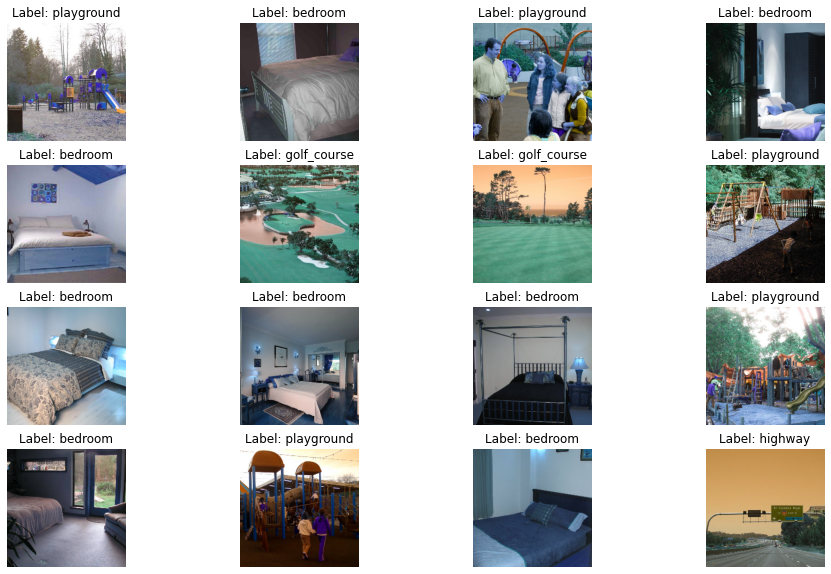

In [8]:
# A list with the names of the image classes
label_names = ['airport_terminal', 'amusement_park', 'bedroom', 'bridge', 'castle', 'conference_room',
               'golf_course', 'highway', 'mountain', 'playground']
               
# Plot a few images to check if the labels make sense
plt.figure(figsize=(16, 10))
for n in range(16):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(4, 4, n+1)
    plt.imshow(train_images[i[0]].astype(int))
    plt.title('Label: ' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

In [18]:
NUM_CLASSES = 11

train_labels_onehot = to_categorical(train_labels, NUM_CLASSES)
val_labels_onehot = to_categorical(val_labels, NUM_CLASSES)
test_labels_onehot = to_categorical(test_labels, NUM_CLASSES)

# Remember:
# 1. If you use one-hot vectors for the labels, the loss function in the model needs to be 'categorical_crossentropy'
# 2. If you use a single class value for the labels, the loss in the model needs to be 'sparse_categorical_crossentropy'

In [12]:
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels_onehot.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels_onehot.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels_onehot.shape))

Images train shape: (2838, 224, 224, 3) - Labels train shape: (2838, 11)
Images validation shape: (710, 224, 224, 3) - Labels validation shape: (710, 11)
Images test shape: (888, 224, 224, 3) - Labels test shape: (888, 11)


In [16]:
def build_model0():
    base_model = tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=INPUT_SHAPE)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    predictions = Dense(NUM_LABELS, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
    
    return model

In [21]:
callbacks = [EarlyStopping(monitor='val_loss',patience = PATIENCE,restore_best_weights=RBW),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience = PATIENCE,min_lr = 1e-7, verbose = 1)]

In [22]:
model = build_model0()

t = datetime.datetime.now()

history = model.fit(x= train_images,
    y= train_labels_onehot,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCH,
    
    validation_data=(val_images, val_labels_onehot),
    verbose=1,
    callbacks=callbacks)

print('Training time: %s\n' % (datetime.datetime.now() - t))

t = datetime.datetime.now()
evals_test = model.evaluate(test_images, labels_test_cat)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))

t = datetime.datetime.now()
evals_test = model.evaluate(val_images, labels_val_cat)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))

t = datetime.datetime.now()
evals_test = model.evaluate(train_images, labels_train_cat)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))

Train on 2838 samples, validate on 710 samples
Epoch 1/50
2838/2838 [==============================] - ETA: 0s - loss: 1.5413 - accuracy: 0.5127

C:\Users\12084\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


2838/2838 [==============================] - 78s 27ms/sample - loss: 1.5413 - accuracy: 0.5127 - val_loss: 0.4877 - val_accuracy: 0.8817 - lr: 1.0000e-05
Epoch 2/50
2838/2838 [==============================] - 65s 23ms/sample - loss: 0.6355 - accuracy: 0.8048 - val_loss: 0.2047 - val_accuracy: 0.9493 - lr: 1.0000e-05
Epoch 3/50
2838/2838 [==============================] - 64s 23ms/sample - loss: 0.3553 - accuracy: 0.8925 - val_loss: 0.1620 - val_accuracy: 0.9479 - lr: 1.0000e-05
Epoch 4/50
2838/2838 [==============================] - 65s 23ms/sample - loss: 0.2522 - accuracy: 0.9271 - val_loss: 0.1448 - val_accuracy: 0.9549 - lr: 1.0000e-05
Epoch 5/50
2838/2838 [==============================] - 65s 23ms/sample - loss: 0.1594 - accuracy: 0.9545 - val_loss: 0.1288 - val_accuracy: 0.9620 - lr: 1.0000e-05
Epoch 6/50
2838/2838 [==============================] - 65s 23ms/sample - loss: 0.1278 - accuracy: 0.9626 - val_loss: 0.1219 - val_accuracy: 0.9676 - lr: 1.0000e-05
Epoch 7/50
2838/2838 

In [24]:
model.save('C://data//data//model//R50_figrim_one')
np.save("C://data//data//model//R50_figrim_one_HistoryDict.npy", history.history)

INFO:tensorflow:Assets written to: C://data//data//model//R50_figrim_one/assets


INFO:tensorflow:Assets written to: C://data//data//model//R50_figrim_one/assets


In [3]:
model = load_model('C://data//data//model//R50_figrim_one')
history = np.load("C://data//data//model//R50_figrim_one_HistoryDict.npy",allow_pickle=True).item()

Instructions for updating:
Colocations handled automatically by placer.


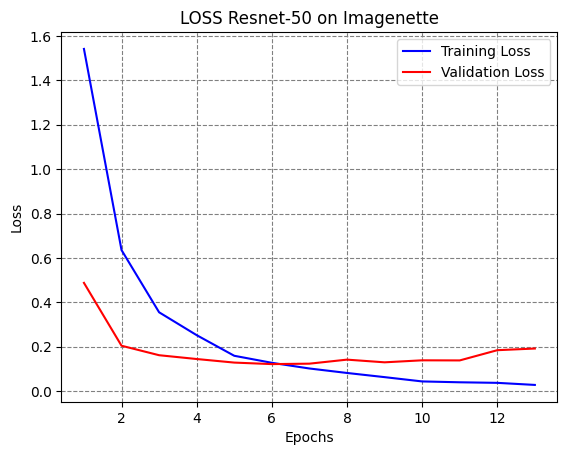

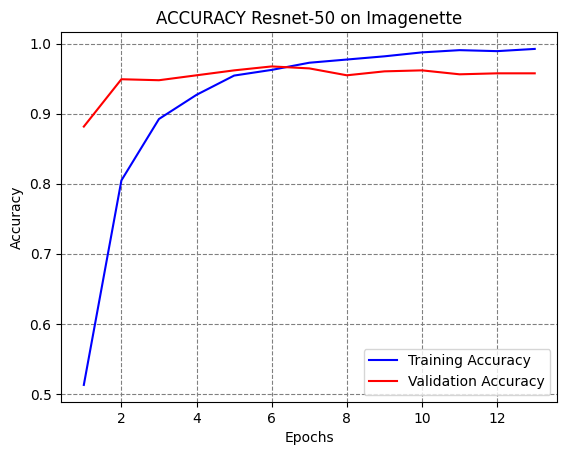

In [4]:
train_loss = history['loss']
val_loss = history['val_loss']
acc = history['accuracy'] 
val_acc = history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS Resnet-50 on Imagenette')
plt.xlabel('Epochs')
plt.ylabel('Loss')

axes = plt.gca()

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY Resnet-50 on Imagenette')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [36]:
#R50_stats = pd.DataFrame(list(zip(eval_R,eval_V,eval_T)),columns = ["training","validate","test"])
#R50_stats= R50_stats.drop(0)
#R50_stats.to_pickle("part1")

In [5]:
part1 = pd.read_pickle("part1")
console = Console()
style = "bold blue"
table = Table('Part1 results:FIGRIM on Resnet-50')
table.add_row(part1.to_string(float_format=lambda _: '{:.2%}'.format(_)))
console.print(table)#,style = style)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Part1 results:FIGRIM on Resnet-50     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           training  validate  testing │
│ VGG-16      97.67%    91.78%   93.12% │
│ Resnet50    98.93%    95.16%   95.41% │
└───────────────────────────────────────┘

__Step 1: When you try to create a single adversarial sample, pay attention to the shapes of the data.__

- Note that the model works with batches of images, so when we have a single image of size (224, 224, 3) we will need to first reshape it into a batch of one image of size (1, 224, 224, 3) before we pass it to the model. 

- **if we feed the image with size (224, 224, 3), we will get an error.**

- Step 2: Using the boundary attack, create an adversarial image that will change the label of the selected original image. 
- use similar parameters for the attack as in the above example notebook in the ART toolbox, or if you wish you can adopt different parameters. Print the L2 norm and the label of the adversarial image for each step of the attack, similar to Figure 3.

- Step 3: Plot the adversarial image with the predicted label by the classifier (as in Figure 4)

- Step 4: Plot the difference between the selected image and the adversarial image, as in Figure 5. Show the color bar of the difference.

Parameters
:
estimator – A trained classifier.

batch_size (int) – The size of the batch used by the estimator during inference.

targeted (bool) – Should the attack target one specific class.

delta (float) – Initial step size for the orthogonal step.

epsilon (float) – Initial step size for the step towards the target.

step_adapt (float) – Factor by which the step sizes are multiplied or divided, must be in the range (0, 1).

max_iter (int) – Maximum number of iterations.

num_trial (int) – Maximum number of trials per iteration.

sample_size (int) – Number of samples per trial.

init_size (int) – Maximum number of trials for initial generation of adversarial examples.

min_epsilon (float) – Stop attack if perturbation is smaller than min_epsilon.

verbose (bool) – Show progress bars.

In [15]:
classifier = KerasClassifier(model = model,clip_values=(0, 1), use_logits=False)
attack_ba = BoundaryAttack(estimator = classifier, 
                           targeted = False, 
                           delta = 0.3, 
                           epsilon = 0.3, 
                           max_iter = 50, 
                           verbose = True)

x_test_adv = attack_ba.generate(imgs_adv)


C:\Users\12084\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Boundary attack:   0%|          | 0/40 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/50 [00:00<?, ?it/s]

In [21]:
loss_test, accuracy_test = model.evaluate(x_test_adv, labels_adv_onehot)
perturbation = np.mean(np.abs((x_test_adv - imgs_adv)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 17.50%
Average perturbation: 105.75


In [ ]:
def plot_images(index):
    
    round((pgd_acc_list[i] * 100),1)
    
    plt.figure(figsize=(16, 16), dpi=150)
    #plot unperturbed images
    plt.subplot(1,3,1)
    plt.title('Label BASE:' + str(signnames[14] + '\n' + 'Perturbation:' + str(0) + '/255'))
    plt.imshow(imgs_stop_signs[0])
    #pgd
    plt.subplot(1,3,2)
    plt.title('Label PGD:' + str(signnames[pgd_pred_list[index]]) + '\n' + 'Perturbation:' + str(round(epsilon_list[index],4)) + 
              '\nAccuracy on  PGD Targeted:' + str(round((pgd_acc_list[i] * 100),1)))
    plt.imshow(image_list_pgd[index])
    #fgsm
    plt.subplot(1,3,3)
    plt.title('Label FGSM:' + str(signnames[fgsm_pred_list[index]]) + '\n' + 'Perturbation:' + str(round(epsilon_list[index],4)) + 
             '\nAccuracy on FGSM Targeted:' + str(round((fgsm_acc_list[i] * 100),1)))
    plt.imshow(image_list_fgsm[index])
    
    plt.show



    
for i in range(len(epsilon_list)):

    plot_images(i)